In [1]:
import numpy as np
import pandas as pd

from datetime import timedelta
import matplotlib.pyplot as plt
import os

from Models import VAR_Funcs as vrf
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

In [2]:
vw_race = 'United States Grand Prix'   # The race to be viewed
dsp_drv = 'LEC' #Error Metrics for an arbitrarily chosen driver

In [3]:
data_df = pd.read_csv('Data/F1_Sector_Dataset.csv')

df = vrf.read_data(data_df)

# Race Speed/ Qual Speed

df['Sec1_Norm'] = df['Race_Sec1_Spd']/df['Qual_Sec1_Spd']
df['Sec2_Norm'] = df['Race_Sec2_Spd']/df['Qual_Sec2_Spd']
df['Sec3_Norm'] = df['Race_Sec3_Spd']/df['Qual_Sec3_Spd']

# First difference for Time Series Forecasting

df['Sec1_Diff'] = df['Sec1_Norm'].diff()   
df['Sec2_Diff'] = df['Sec2_Norm'].diff()
df['Sec3_Diff'] = df['Sec3_Norm'].diff()

In [4]:
res_df = vrf.adf_data_eval(df)

stt_tser = len(res_df.loc[res_df['p_value'] < 0.05])
tot_tser = len(res_df)

print ("Out of ",tot_tser," time series ",stt_tser,"time series are stationary")

Out of  5601  time series  5001 time series are stationary


In [5]:
stn_df = res_df.loc[res_df['p_value'] < 0.05].groupby(['Date', 'Race', 'Driver']).agg({'Column' : 'nunique'}).reset_index()
stn_df = stn_df.loc[stn_df['Column'] == 3].reset_index(drop = True)

old_len = len(df)
df = pd.merge(df, stn_df[['Date', 'Race', 'Driver']], how = 'inner')
new_len = len(df)

print("Only the laps where all 3 sectors are stationary are used going forward")
print(new_len, " laps remain out of ", old_len, " laps")

Only the laps where all 3 sectors are stationary are used going forward
81270  laps remain out of  109837  laps


In [6]:
lag_df = vrf.pacf_calc(df)

lag_df['Avg_Pacf'] = (lag_df['Sec1_Pacf'] + lag_df['Sec2_Pacf'] + lag_df['Sec3_Pacf'])/3

max_lag = lag_df.loc[lag_df['Avg_Pacf'].idxmax(), 'Lag']

print ('Lag ', max_lag, ' has the highest PACF')
lag_df.head()

Lag  1  has the highest PACF


,Lag,Sec1_Pacf,Sec2_Pacf,Sec3_Pacf,Avg_Pacf
0,1,0.64,0.77,0.77,0.726667
1,2,0.45,0.49,0.53,0.490000
2,3,0.38,0.40,0.39,0.390000
3,4,0.46,0.36,0.34,0.386667
4,5,0.30,0.34,0.39,0.343333


In [7]:
df_var = vrf.var(df, max_lag) #VAR Regression Model

dsp_df = df_var.loc[(df_var['Race'] == vw_race) & (df_var['Driver'] == dsp_drv) & (df_var['Date'].dt.year == 2024)].reset_index(drop = True)
err_sec = dsp_df['Err_Drv_Spd'].mean()

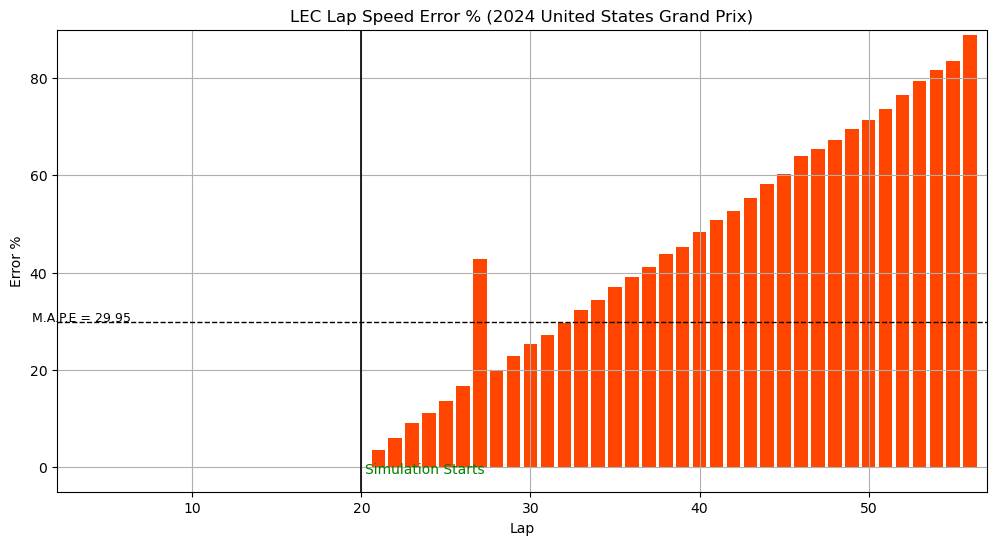

In [8]:
plt.figure(figsize=(12, 6))
plt.bar(dsp_df['Lap_Num'], dsp_df['Err_Drv_Spd'], label = 'Real Speed', color = 'orangered')

plt.xlabel('Lap')
plt.ylabel('Error %')
plt.title(dsp_drv + ' Lap Speed Error % (2024 ' + vw_race + ')')

plt.axvline(x = 20, color='black', linestyle='-', linewidth = 1.2, label='Simulation Starts')
plt.axhline(y = err_sec, color='black', linestyle='--', linewidth = 1, label = 'M.A.P.E')

plt.text(x=0.5, y = err_sec + 0.1, s=f'M.A.P.E = {err_sec:.2f}', color='black', fontsize=9)

plt.text(20.2, (dsp_df['Err_Drv_Spd'].min() - 0.5), 'Simulation Starts',
         verticalalignment='center', horizontalalignment='left', color='green')


plt.xlim(dsp_df['Lap_Num'].min(), dsp_df['Lap_Num'].max()+1)
plt.ylim(min(dsp_df['Err_Drv_Spd'].min() - 1, -5), max(dsp_df['Err_Drv_Spd'].max() + 1, 5))

plt.grid(True)